In [39]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from ipywidgets import Checkbox, interact_manual, HBox, VBox, Button, Output, DatePicker, Label
from IPython.display import clear_output
from math import ceil


In [21]:
def pull_data():
    url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
    df = pd.read_csv(url,error_bad_lines=False)
    df.replace('United Kingdom', 'UK', inplace=True)
    print('Data pulled')
    return df

In [40]:
def run_analysis(since, **kwargs):

    if all(v is False for v in kwargs.values()):
        return

    #plt.xkcd()
    #plt.style.use('seaborn-poster')   
    
    countries_dict = {k : 'country' for k,v in kwargs.items() if v}
    
    # Need to fix this ------------------
    if 'World' in countries_dict.keys():
        countries_dict['World'] = 'world'
    
    if 'Quebec' in countries_dict.keys():
        countries_dict['Quebec'] = 'region'
    # ------------------

    doubling_results = {}
        
    fig = plt.figure(figsize=(15, 20))
    ax1 = fig.add_subplot(311)
    ax2 = fig.add_subplot(312)
    ax3 = fig.add_subplot(313)
    
    for country, area_type in countries_dict.items():
            
        if area_type == 'region':
            q = pd.DataFrame(df[df['Province/State'] == country].sum()[4:])
        elif area_type == 'country':
            q = pd.DataFrame(df[df['Country/Region'] == country].sum()[4:])
        elif area_type == 'world':
            q = pd.DataFrame(df.sum()[4:])
        q.reset_index(inplace=True)
        q.columns = ['date', 'cases']
        q['date'] = q.date.apply(pd.to_datetime)
        q.set_index(q.date, inplace=True)
        q = q.loc[since:]


        # Plot 1: log cases per day
        q['cases'].plot(ax=ax1)
        ax1.legend(countries_dict.keys());
        ax1.set_yscale('log', basey=2)
        ax1.set_title('Total recorded cases by country/region')

        # Get doubling time per country for plot 2
        r = q.copy()
        r['cases'] = r.cases.apply(lambda x: np.log2(x))
        x = r['cases'].min()
        if x == float("inf") or x == float("-inf"):
            x=0
        rate = (r['cases'].max() - x) / (r['date'].max() - r['date'].min()).days
        period = 1/rate
        doubling_results[country] = period

        # Plot 3: New cases 3-day rolling average
        n = 5
        q['dc/dt'] = q['cases'].diff()
        q['rolling'] = q['dc/dt'].rolling(n).mean()

        max_change = q['rolling'].max()
        q['rolling'] = q['rolling'].apply(lambda x: x/ max_change)
        q['rolling'].plot(ax = ax3);
        ax3.legend(countries_dict.keys());
        ax3.set_title(f'New daily cases by country/region, {n}-day rolling average as function of maximum')


    # Plot 2 : doubling time
    pd.DataFrame(pd.Series(doubling_results).sort_values(ascending=False)).plot(kind='bar', ax=ax2)
    ax2.set_title(f'Case doubling time by country/region since {since}')
    
    plt.tight_layout()

In [49]:
# Pull data
df = pull_data()

# Create list of checkboxes
l = list(df['Country/Region'].unique()) + ['Quebec', 'World']
chk = [Checkbox(description=a) for a in l]

# Create datepicker widget for 'since' argument. Put in box for long name.
date = DatePicker()
date_box= HBox([Label('Analyse cases since:'), date])


# Organize checkboxes into HBox(Vboxes) layout
width = 4
height = ceil(len(l)/width)
v_boxes = [VBox(chk[(i*height): (i+1)*height]) for i in range(width)]
checkboxes = HBox(v_boxes)

# Create button and output widgets, assign function to button and write to output
button = Button(description="Run Analysis")
output = Output()

def run_and_output(button):
    since = date.value.strftime("%-m/%-d/%Y")
    clear_output()
    with output:
        run_analysis(since=since, **{c.description: c.value for c in chk})
    display(all_widgets)

button.on_click(run_and_output)

# Assemble widgets into one box
all_widgets = VBox([date_box, checkboxes, button, output])

Data pulled


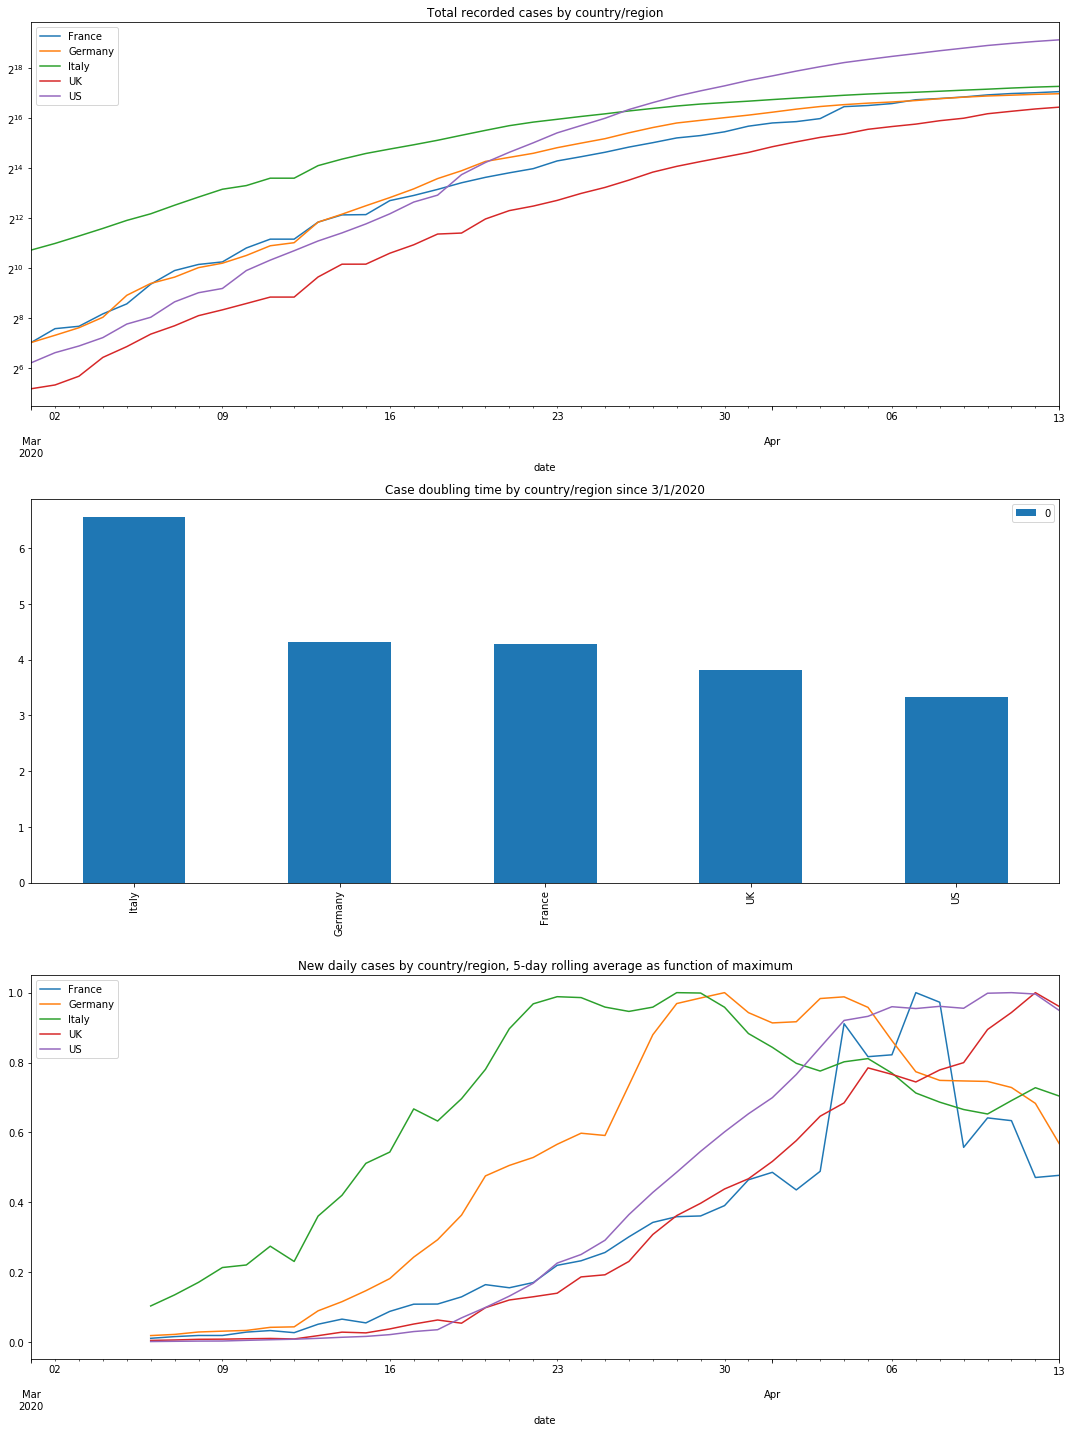

In [50]:
# Cast widgets to screen
print('Select countries to analyse:')
display(all_widgets)